In [1]:
#Grab Data
import yfinance as yf

#Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
#USD/EUR price levels for the past 14 years
symbol = 'EUR=X'
raw = yf.download(symbol, start="2010-01-01", end="2024-01-01")['Adj Close']

data = pd.DataFrame(raw)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head()

,Adj Close
Date,
2010-01-01,0.69493
2010-01-04,0.69329
2010-01-05,0.69609
2010-01-06,0.69425
2010-01-07,0.69842


In [4]:
#Calculate the returns and add it to the DataFrame
data['return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

#When the market direction is greater than 0 --> classify 1, less than 0 --> 0
data['direction'] = np.where(data['return'] > 0, 1, 0)

data.head()

,Adj Close,return,direction
Date,,,
2010-01-01,0.69493,NaN,0
2010-01-04,0.69329,-0.002363,0
2010-01-05,0.69609,0.004031,1
2010-01-06,0.69425,-0.002647,0
2010-01-07,0.69842,0.005989,1


In [5]:
#Create 5 columns for each lag representing previous day's return
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  data[col] = data['return'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)

In [6]:
data.round(4).tail()

,Adj Close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2023-12-25,0.9069,-0.0019,0,-0.0055,0.0032,-0.0052,-0.0026,0.0090
2023-12-26,0.9074,0.0006,1,-0.0019,-0.0055,0.0032,-0.0052,-0.0026
2023-12-27,0.9056,-0.0021,0,0.0006,-0.0019,-0.0055,0.0032,-0.0052
2023-12-28,0.9002,-0.0059,0,-0.0021,0.0006,-0.0019,-0.0055,0.0032
2023-12-29,0.9035,0.0036,1,-0.0059,-0.0021,0.0006,-0.0019,-0.0055


# Deep Neural Network Stuff

In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
import random

In [8]:
optimizer = Adam(learning_rate=0.0001)

def set_seeds(seed=100):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(100)

In [9]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
train_set, test_set = np.split(data, [int(.70 *len(data))])

In [11]:
mu, std = train_set.mean(), train_set.std()

In [12]:
# Normalizes the features data by Gaussian normalization
training_data_ = (train_set - mu) / std
test_data_ = (test_set - mu) / std

In [13]:
%%time
model.fit(train_set[cols],
           train_set['direction'],
           epochs=50, verbose=False,
           validation_split=0.2, shuffle=False)



CPU times: total: 8.31 s
Wall time: 6.14 s


In [14]:
res = pd.DataFrame(model.history.history)

<Axes: >

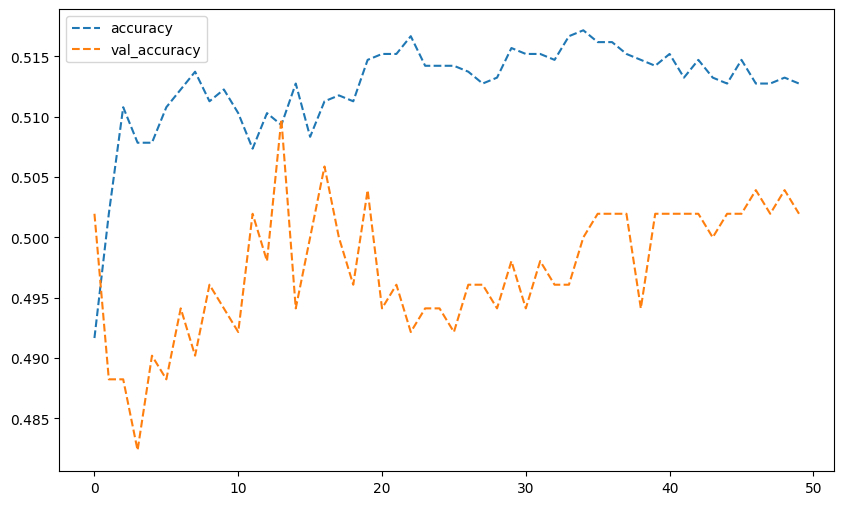

In [15]:
# Accuracy of the model for training and validation in the training set
res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')

In [16]:
model.evaluate(training_data_[cols], train_set['direction'])

80/80 [==============================] - 0s 1ms/step - loss: 0.9424 - accuracy: 0.5122


[0.9424065947532654, 0.5121663808822632]

In [17]:
# Creating Prediction of market direction
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

80/80 [==============================] - 0s 723us/step


In [18]:
pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [19]:
pred[:30].flatten()

array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1])

In [20]:
# Transforming the predictions to long-short position; 1,-1
train_set['prediction'] = np.where(pred > 0, 1, -1)

In [21]:
# Calculate strategy returns given the positions
train_set['strategy'] = (train_set['prediction'] * train_set['return'])

In [22]:
train_set[['return', 'strategy']].sum().apply(np.exp)

return      1.294880
strategy    1.573747
dtype: float64

<Axes: xlabel='Date'>

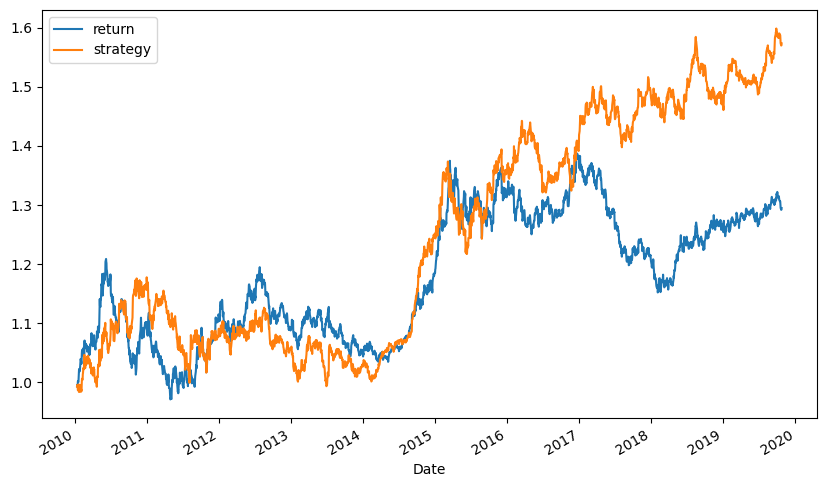

In [23]:
# Plots the strategy returns to the benchmark performance for the sample
train_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

# Same Process on the Out-of-Sample Test Set

In [24]:
model.evaluate(test_data_[cols], test_set['direction'])

35/35 [==============================] - 0s 2ms/step - loss: 0.9351 - accuracy: 0.4881


[0.9351086020469666, 0.488095223903656]

In [25]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

35/35 [==============================] - 0s 707us/step


In [26]:
test_set['prediction'] = np.where(pred > 0, 1, -1)

In [27]:
test_set['prediction'].value_counts()

prediction
 1    718
-1    374
Name: count, dtype: int64

In [28]:
test_set['strategy'] = (test_set['prediction'] * test_set['return'])

In [29]:
test_set[['return', 'strategy']].sum().apply(np.exp)

return      1.005520
strategy    0.959891
dtype: float64

<Axes: xlabel='Date'>

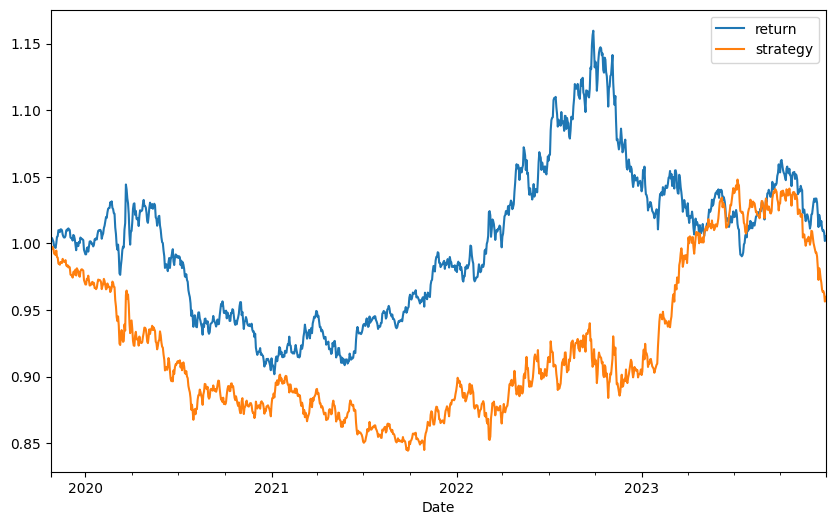

In [30]:
test_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

# Adding More Features

In [31]:
#Add momentum, volatitlity, & distance to the data_frame
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['Adj Close'] - data['Adj Close'].rolling(50).mean()).shift(1)

In [32]:
data.dropna(inplace=True)

In [33]:
cols.extend(['momentum', 'volatility', 'distance'])

In [34]:
# New DataFrame
data.round(4).tail()

,Adj Close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2023-12-25,0.9069,-0.0019,0,-0.0055,0.0032,-0.0052,-0.0026,0.0090,-0.0002,0.0050,-0.0199
2023-12-26,0.9074,0.0006,1,-0.0019,-0.0055,0.0032,-0.0052,-0.0026,-0.0024,0.0050,-0.0207
2023-12-27,0.9056,-0.0021,0,0.0006,-0.0019,-0.0055,0.0032,-0.0052,-0.0018,0.0050,-0.0194
2023-12-28,0.9002,-0.0059,0,-0.0021,0.0006,-0.0019,-0.0055,0.0032,-0.0011,0.0049,-0.0205
2023-12-29,0.9035,0.0036,1,-0.0059,-0.0021,0.0006,-0.0019,-0.0055,-0.0030,0.0050,-0.0248


In [35]:
# Refit and train/test
train_data, test_data = np.split(data, [int(.70 *len(data))])
mu, std = train_data.mean(), train_data.std()

In [36]:
training_data_ = (train_data - mu) / std
test_data_ = (test_data - mu) / std

In [37]:
# Update Dense Layers to 32
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
model.evaluate(training_data_[cols], train_data['direction'])

79/79 [==============================] - 0s 924us/step - loss: 0.7413 - accuracy: 0.4899


[0.7413451075553894, 0.48985275626182556]

In [39]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

79/79 [==============================] - 0s 694us/step


In [40]:
train_data['prediction'] = np.where(pred > 0, 1, -1)

In [41]:
train_data['strategy'] = (train_data['prediction'] * train_data['return'])

In [42]:
train_data[['return', 'strategy']].sum().apply(np.exp)

return      1.229248
strategy    1.236736
dtype: float64

<Axes: xlabel='Date'>

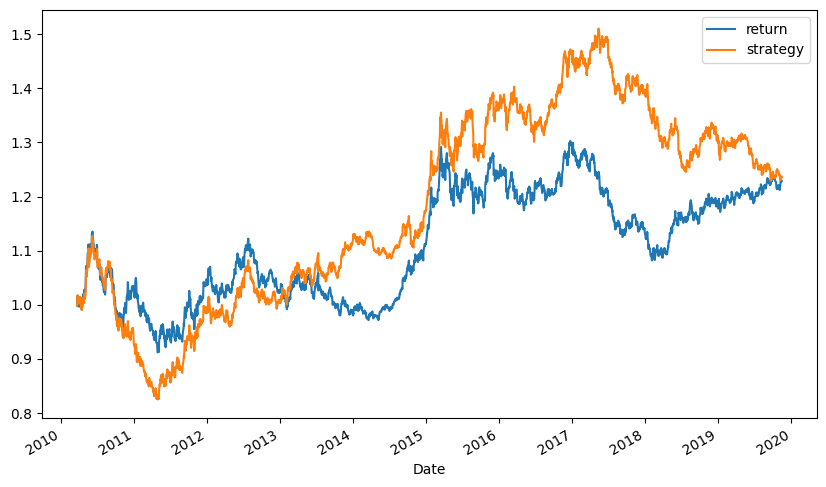

In [43]:
train_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [44]:
model.evaluate(test_data_[cols], test_data['direction'])

34/34 [==============================] - 0s 821us/step - loss: 0.7281 - accuracy: 0.4773


[0.7281212210655212, 0.4772516191005707]

In [45]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

34/34 [==============================] - 0s 637us/step


In [46]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [47]:
test_set['prediction'].value_counts()

prediction
 1    718
-1    374
Name: count, dtype: int64

In [48]:
test_set['strategy'] = (test_set['prediction'] * test_set['return'])

In [49]:
test_set[['return', 'strategy']].sum().apply(np.exp)

return      1.005520
strategy    0.959891
dtype: float64

<Axes: xlabel='Date'>

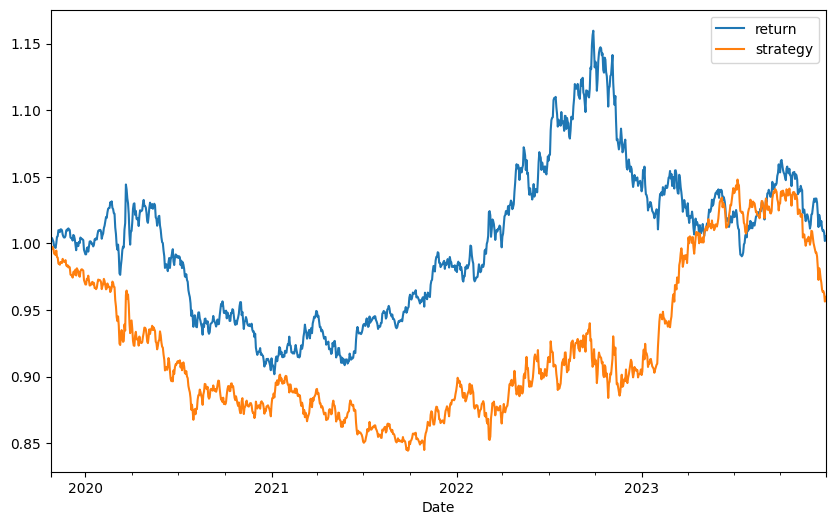

In [50]:
test_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))